# Census and Behavioral Risk Factor regression analysis

Following the preprocessing and merging of the 9 Census and BRFSS datasets in `census_data_cleaning.ipynb`, I will now perform analysis on the datasets. I wish to perform regression analysis to predict the **rate of poverty** in each county. 

The regression is performed in 2 datasets:
1. The larger census dataset, without BRFSS
2. The shortened dataset, including census and BRFSS data

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn import linear_model
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_census = pd.read_pickle('../Data/census/data_census.pkl')
data_brfss = pd.read_pickle('../Data/census/data_brfss.pkl')

# Data cleaning on `data_census`

In [3]:
data_census.head()

,FIPS,State,County_Name,CENSUS_2010_POP,FIPS_int,AVE_POP_CHG,AVE_BIRTHS,AVE_DEATHS,AVE_INTERNATIONAL_MIG,AVE_DOMESTIC_MIG,...,Associate,Bachelor_GT,Percent_LT_HighSchool,Percent_HighSchool,Percent_Associate,Percent_Bachelor_GT,Heart_mortality_rate,Stroke_mortality_rate,AVE_BIRTH_RATE,Percent_High_Speed
0,01001,AL,Autauga County,54571,1001,105.875,637.000,550.500,4.000,16.875,...,10552.0,10291.0,11.3,32.6,28.4,27.7,425.0,96.5,34.31875,0.75
1,01003,AL,Baldwin County,182265,1003,4363.875,2218.875,2006.750,170.500,3934.375,...,46025.0,46075.0,9.7,27.6,31.3,31.3,383.5,83.5,38.39375,0.92
2,01005,AL,Barbour County,27457,1005,-306.125,282.875,306.375,4.750,-288.750,...,4566.0,2220.0,27.0,35.7,25.1,12.2,493.8,88.0,57.95625,0.54
3,01007,AL,Bibb County,22915,1007,-59.000,258.625,253.250,13.875,-77.250,...,3846.0,1813.0,16.8,47.3,24.4,11.5,433.8,110.1,46.21250,NaN
4,01009,AL,Blount County,57322,1009,58.375,684.750,623.375,19.500,-16.875,...,13267.0,5010.0,19.8,34.0,33.5,12.6,416.5,89.1,42.26875,0.62


In [4]:
data_census.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3114 entries, 0 to 3113
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FIPS                        3114 non-null   object 
 1   State                       3114 non-null   object 
 2   County_Name                 3114 non-null   object 
 3   CENSUS_2010_POP             3114 non-null   int64  
 4   FIPS_int                    3114 non-null   int64  
 5   AVE_POP_CHG                 3114 non-null   float64
 6   AVE_BIRTHS                  3114 non-null   float64
 7   AVE_DEATHS                  3114 non-null   float64
 8   AVE_INTERNATIONAL_MIG       3114 non-null   float64
 9   AVE_DOMESTIC_MIG            3114 non-null   float64
 10  ABS_POVERTY                 3114 non-null   int64  
 11  PERCENT_POVERTY             3114 non-null   float64
 12  ABS_POVERTY_CHILDREN        3114 non-null   int64  
 13  PERCENT_POVERTY_CHILDREN    3114 

Now that we have a complete dataset, we do not need identifier columns such as `FIPS`, `State` and `County_Name` anymore. We will drop these columns. We also see that there are 3 columns of median household incomes `Median_HH_Income_pct_state`, `MEDIAN_HH_INCOME` and `Med_HH_Income`; we prefer to keep the normalized column `Median_HH_Income_pct_state` instead of the absolute median incomes.

The dependent variable we are interested is `PERCENT_POVERTY`. We see that `PERCENT_POVERTY` is highly correlated with other poverty-related variables, such as `PERCENT_POVERTY_CHILDREN`. Therefore, we will also drop these poverty columns.

From the education data, we have both the absolute column and percent column, such as the pair `LT_HighSchool` for absolute number of people with less than a high school degree and `Percent_LT_HighSchool` for percentage of people with less than a high school degree. Therefore, we will drop all absolute value columns.

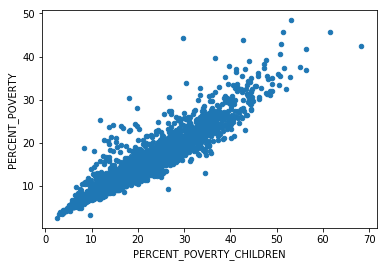

In [5]:
data_census.plot.scatter(x='PERCENT_POVERTY_CHILDREN', y='PERCENT_POVERTY')
plt.show()

In [6]:
data_census.drop(columns=['FIPS','State','County_Name','FIPS_int','PERCENT_POVERTY_CHILDREN','ABS_POVERTY_CHILDREN','ABS_POVERTY','MEDIAN_HH_INCOME','Med_HH_Income'], axis=1, inplace=True)
data_census.drop(columns=['LT_HighSchool', 'HighSchool', 'Associate', 'Bachelor_GT'], axis=1, inplace=True)

There are several columns that are in *absolute* population count instead of *rates* or *percentages*, such as the `AVE_POP_CHG` column shown below. We will normalize these columns by the total county population `CENSUS_2010_POP`.
* `AVE_POP_CHG` to `Pop_change_rate`
* `AVE_DEATHS` to `Death_rate`
* `AVE_INTERNATIONAL_MIG` to `Intl_migration_rate`
* `AVE_DOMESTIC_MIG` to `Domestic_migration_rate`
* `AVE_BIRTHS` is removed because duplicate `AVE_BIRTH_RATE`

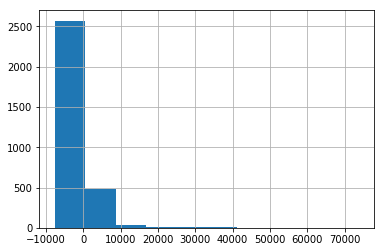

In [7]:
data_census['AVE_POP_CHG'].hist()
plt.show()

In [8]:
data_census['Pop_change_rate'] = data_census['AVE_POP_CHG'] / data_census['CENSUS_2010_POP']
data_census['Death_rate'] = data_census['AVE_DEATHS'] / data_census['CENSUS_2010_POP']
data_census['Intl_migration_rate'] = data_census['AVE_INTERNATIONAL_MIG'] / data_census['CENSUS_2010_POP']
data_census['Domestic_migration_rate'] = data_census['AVE_DOMESTIC_MIG'] / data_census['CENSUS_2010_POP']
data_census.drop(columns=['AVE_POP_CHG','AVE_DEATHS','AVE_BIRTHS','AVE_INTERNATIONAL_MIG','AVE_DOMESTIC_MIG'], axis=1, inplace=True)

In [9]:
# move dependent column PERCENT_POVERTY to the front, index=0
col_order = np.linspace(0,16,17)
col_order[1] = 0
col_order[0] = 1
data_census = data_census.iloc[:,col_order]
data_census.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3114 entries, 0 to 3113
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PERCENT_POVERTY             3114 non-null   float64
 1   CENSUS_2010_POP             3114 non-null   int64  
 2   Metropolitan                3114 non-null   int64  
 3   Median_HH_Income_pct_state  3114 non-null   float64
 4   Ave_Unemployed_Rate         3114 non-null   float64
 5   Percent_LT_HighSchool       3114 non-null   float64
 6   Percent_HighSchool          3114 non-null   float64
 7   Percent_Associate           3114 non-null   float64
 8   Percent_Bachelor_GT         3114 non-null   float64
 9   Heart_mortality_rate        3114 non-null   float64
 10  Stroke_mortality_rate       3114 non-null   float64
 11  AVE_BIRTH_RATE              3114 non-null   float64
 12  Percent_High_Speed          2904 non-null   float64
 13  Pop_change_rate             3114 

We notice that all columns have 3114 non-null rows, except for `Percent_High_Speed` for the percentage of households with high-speed Internet connections. Let's investigate the histogram of this column and see if we can impute the missing ~200 values.

The distribution in the histogram below looks normal, with a few outliers. We will assume normality for this feature and use mean-imputation to fill in the missing values.

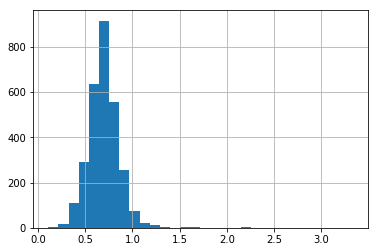

In [10]:
data_census['Percent_High_Speed'].hist(bins=30)

In [11]:
data_census['Percent_High_Speed'] = data_census['Percent_High_Speed'].fillna(data_census['Percent_High_Speed'].mean())

# Data exploration on `data_census`

Let's look at the correlation heatmap between `PERCENT_POVERTY` and the rest of the predictors.

In [12]:
correlations = data_census.corr()

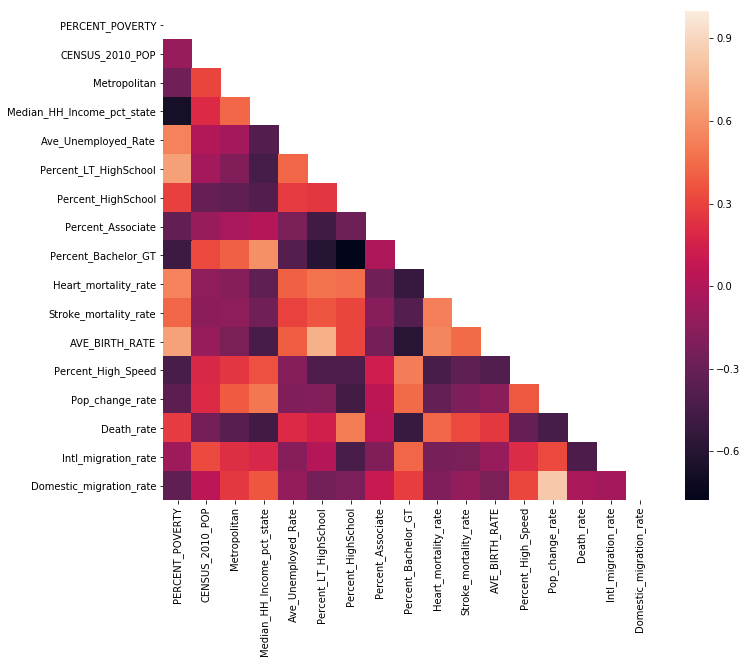

In [13]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(correlations, xticklabels=data_census.columns, yticklabels=data_census.columns,
           mask=np.triu(np.ones_like(correlations, dtype=bool)))

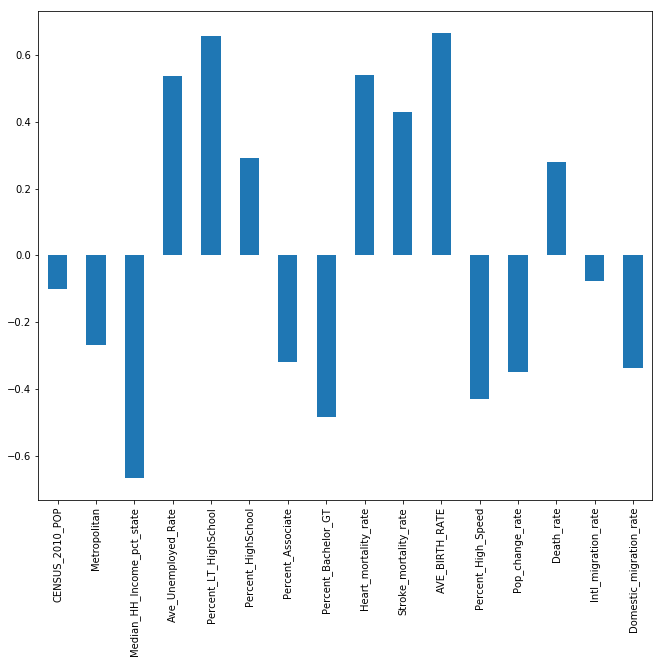

In [14]:
f, ax = plt.subplots(figsize=(11, 9))
correlations['PERCENT_POVERTY'][1:].plot.bar() # exclude autocorr

These variables have > 0.4 |correlations| with `PERCENT_POVERTY`:
* `Median_HH_Income_pct_state`
* `Ave_Unemployed_Rate`
* `Percent_LT_HighSchool`
* `Percent_Bachelor_GT`
* `Heart_mortality_rate`
* `Stroke_mortality_rate`
* `AVE_BIRTH_RATE`
* `Percent_High_Speed`

Let's perform regression modeling with all predictors first, then compare it with this subset of predictors.
We will start off with 4 out-of-the-box linear regression models from sklearn:
* Ordinary Least Squares linear regression
* ElasticNet regression
* Support Vector regression
* Random Forest regression

# Data analysis on `data_census`

We now standardize all columns and split the data into training and testing (20%) sets. 

In [15]:
y_data = data_census.iloc[:,0] # first column PERCENT_POVERTY
x_data = data_census.iloc[:,1:] # remaining columns
features = data_census.iloc[:,1:].columns

In [16]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_data)
x_data = scaler.transform(x_data) # no scaling y

In [17]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.2, random_state=0)

**OLS Regression**

In [18]:
ols = linear_model.LinearRegression() # out-of-the-box
ols.fit(x_train, y_train)
y_preds = ols.predict(x_test)

In [19]:
# calculate r_squared and rmse
def evaluate_model(model, x_test, y_test):
    y_preds = model.predict(x_test)
    r_squared = model.score(x_test,y_test)
    rmse = metrics.mean_squared_error(y_test,y_preds)
    return r_squared, rmse

In [20]:
evaluate_model(ols, x_test, y_test)

(0.7411923852963731, 9.712207380975489)

OLS seems to perform fairly well, with `r_squared` of 0.74 and `rmse` of 9.7.

**ElasticNet Regression**

This is linear regression with combined L1 and L2 regularizers. ElasticNet is basically the combination of Ridge Regression and Lasso Regression. ElasticNet performs with `r_squared` of 0.65 and `rmse` of 12.9, which is worse than the OLS regression.

In [21]:
enet = linear_model.ElasticNet() # out-of-the-box
enet.fit(x_train, y_train)
evaluate_model(enet, x_test, y_test)

(0.657233471131947, 12.862912149767594)

**Support Vector Regression**

This is similar to support vector machine, but used for regression analysis purposes. SVR yields similar results with OLS, with `r_squared` of 0.76 and `rmse` of 8.9.

In [22]:
svr = svm.SVR() # out-of-the-box
svr.fit(x_train, y_train)
evaluate_model(svr, x_test, y_test)

(0.7637786384825718, 8.864618815411905)

**Random Forest Regression**

Random Forest does the best out of all the regression models, yielding `r_squared` 0.82 and `rmse` 6.5.

In [23]:
forest = ensemble.RandomForestRegressor(random_state=0) # out-of-the-box
forest.fit(x_train, y_train)
evaluate_model(forest, x_test, y_test)

(0.8192313532485916, 6.783658924558589)

Now let us repeat this entire experiment again, but this time with the smaller subset of predictors we identified with high univariate correlations with `PERCENT_POVERTY`.

In [24]:
subset_cols = ['Median_HH_Income_pct_state','Ave_Unemployed_Rate','Percent_LT_HighSchool','Percent_Bachelor_GT',
               'Heart_mortality_rate','Stroke_mortality_rate','AVE_BIRTH_RATE','Percent_High_Speed']
subset_cols_idx = [i for i in range(len(features)) if features[i] in subset_cols]
x_train_subset = x_train[:,subset_cols_idx]
x_test_subset = x_test[:,subset_cols_idx]

In [25]:
def out_of_the_box(x_train_subset, x_test_subset):
    ols = linear_model.LinearRegression() # out-of-the-box
    ols.fit(x_train_subset, y_train)
    print('OLS: (r_squared, rmse) = {} '.format(evaluate_model(ols, x_test_subset, y_test)))

    enet = linear_model.ElasticNet() # out-of-the-box
    enet.fit(x_train_subset, y_train)
    print('ElasticNet: (r_squared, rmse) = {} '.format(evaluate_model(enet, x_test_subset, y_test)))

    svr = svm.SVR() # out-of-the-box
    svr.fit(x_train_subset, y_train)
    print('SVR: (r_squared, rmse) = {} '.format(evaluate_model(svr, x_test_subset, y_test)))

    forest = ensemble.RandomForestRegressor(random_state=0) # out-of-the-box
    forest.fit(x_train_subset, y_train)
    print('Forest: (r_squared, rmse) = {} '.format(evaluate_model(forest, x_test_subset, y_test)))
out_of_the_box(x_train_subset, x_test_subset)

OLS: (r_squared, rmse) = (0.7305849724699622, 10.110269058038961) 
ElasticNet: (r_squared, rmse) = (0.6453509386660249, 13.308824916485706) 
SVR: (r_squared, rmse) = (0.7597783470143918, 9.014736733572086) 
Forest: (r_squared, rmse) = (0.7959061324501806, 7.658978539325843) 


It looks like we might have removed too many features, since all 4 regression models show a decrease in `r_squared` and `rmse` evaluation measures. 

Since removal of features using univariate correlation coefficients did not work, let's determine prominent features using:
1. ElasticNet attribute `coef_`. ElasticNet uses L1 regularization which forces some coefficients to 0 and has embedded feature selection characteristic.
2. RandomForest attribute `feature_importances_`. RandomForest uses the reduction of entropy to determine which feature minimizes data entropy.

In [26]:
# ElasticNet
enet = linear_model.ElasticNet() # out-of-the-box
enet.fit(x_train, y_train)
enet_coefs_dict = dict(zip(features, enet.coef_))
enet_coefs_dict

{'CENSUS_2010_POP': -0.0,
 'Metropolitan': -0.0,
 'Median_HH_Income_pct_state': -1.3680464535461168,
 'Ave_Unemployed_Rate': 0.7107503102499959,
 'Percent_LT_HighSchool': 0.8598900303575654,
 'Percent_HighSchool': -0.0,
 'Percent_Associate': -0.27040398294974416,
 'Percent_Bachelor_GT': -0.0,
 'Heart_mortality_rate': 0.44789019151728343,
 'Stroke_mortality_rate': 0.23180620026144724,
 'AVE_BIRTH_RATE': 0.9983040207916795,
 'Percent_High_Speed': -0.22908077306328614,
 'Pop_change_rate': -0.0,
 'Death_rate': 0.0,
 'Intl_migration_rate': 0.0,
 'Domestic_migration_rate': -0.18040678578395022}

This list of features chosen from ElasticNet `coef_` are quite similar to the subset of features we have chosen before from the univariate correlation coefficients. We will still try to evaluate whether this subset improves our regression analysis.

In [27]:
features_enet = [k for (k,v) in enet_coefs_dict.items() if np.abs(v) > 0.01]
features_enet

['Median_HH_Income_pct_state',
 'Ave_Unemployed_Rate',
 'Percent_LT_HighSchool',
 'Percent_Associate',
 'Heart_mortality_rate',
 'Stroke_mortality_rate',
 'AVE_BIRTH_RATE',
 'Percent_High_Speed',
 'Domestic_migration_rate']

In [28]:
# Random Forest
forest = ensemble.RandomForestRegressor() # out-of-the-box
forest.fit(x_train, y_train)
forest_importance_dict = dict(zip(features, forest.feature_importances_))
forest_importance_dict

{'CENSUS_2010_POP': 0.015242713909985207,
 'Metropolitan': 0.0010871870303429526,
 'Median_HH_Income_pct_state': 0.2886838830799487,
 'Ave_Unemployed_Rate': 0.037256776928654686,
 'Percent_LT_HighSchool': 0.17688979389000886,
 'Percent_HighSchool': 0.01377338439965478,
 'Percent_Associate': 0.017305615054154677,
 'Percent_Bachelor_GT': 0.018927828716246774,
 'Heart_mortality_rate': 0.02761315415193154,
 'Stroke_mortality_rate': 0.021827100212980313,
 'AVE_BIRTH_RATE': 0.27166310437372754,
 'Percent_High_Speed': 0.012373290116588186,
 'Pop_change_rate': 0.01697436942189417,
 'Death_rate': 0.021214725669864296,
 'Intl_migration_rate': 0.020119055558046824,
 'Domestic_migration_rate': 0.039048017485970546}

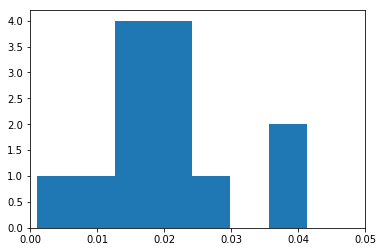

In [29]:
plt.hist(forest_importance_dict.values(), bins=50)
plt.xlim(0,0.05)
plt.show()

From the histogram of the feature importance, we will choose the cutoff of 0.025 for feature importance. If the cutoff is too high, we do not have enough features, but if it is too low the increased variance will affect the goodness of fit. With this cutoff, we retain **6** features from the Random Forest model.

In [30]:
features_forest = [k for (k,v) in forest_importance_dict.items() if np.abs(v) > 0.025]
features_forest

['Median_HH_Income_pct_state',
 'Ave_Unemployed_Rate',
 'Percent_LT_HighSchool',
 'Heart_mortality_rate',
 'AVE_BIRTH_RATE',
 'Domestic_migration_rate']

In [31]:
# All features
# ElasticNet features
print('All:')
out_of_the_box(x_train, x_test)

# ElasticNet features
subset_cols_idx = [i for i in range(len(features)) if features[i] in features_enet]
x_train_subset = x_train[:,subset_cols_idx]
x_test_subset = x_test[:,subset_cols_idx]
print('\nElasticNet:')
out_of_the_box(x_train_subset, x_test_subset)

# RandomForest features
subset_cols_idx = [i for i in range(len(features)) if features[i] in features_forest]
x_train_subset = x_train[:,subset_cols_idx]
x_test_subset = x_test[:,subset_cols_idx]
print('\nRandomForest:')
out_of_the_box(x_train_subset, x_test_subset)

All:
OLS: (r_squared, rmse) = (0.7411923852963731, 9.712207380975489) 
ElasticNet: (r_squared, rmse) = (0.657233471131947, 12.862912149767594) 
SVR: (r_squared, rmse) = (0.7637786384825718, 8.864618815411905) 
Forest: (r_squared, rmse) = (0.8192313532485916, 6.783658924558589) 

ElasticNet:
OLS: (r_squared, rmse) = (0.729812350933414, 10.139263029482024) 
ElasticNet: (r_squared, rmse) = (0.6572333747242664, 12.862915767634048) 
SVR: (r_squared, rmse) = (0.7586476717562117, 9.057167295750709) 
Forest: (r_squared, rmse) = (0.8109698482173906, 7.093686317817016) 

RandomForest:
OLS: (r_squared, rmse) = (0.7064376208338092, 11.016440567174113) 
ElasticNet: (r_squared, rmse) = (0.6403110032101835, 13.497957289541716) 
SVR: (r_squared, rmse) = (0.762256888926798, 8.921725123062503) 
Forest: (r_squared, rmse) = (0.7919698380577762, 7.80669485553772) 


Looking at the `r_squared` and `rmse` from the 3 sets of features, we have shown that using all 16 features yields `r_squared` of 0.82, but decreasing the number of features 6 and the `r_squared` only decreased slightly to 0.79. Therefore, from this point on, we will perform analysis with our 6 most important features.

**Model tuning**

We will tune each of the regression models using cross-validation instead of using the out-of-the-box regressors. Let's see if tuning the hyperparameters will show improvement to our `PERCENT_POVERTY` predictions. The OLS model does not have hyperparameters to tune, so this section only applies to the ElasticNet, SVR and RandomForest models.

**Model tuning: ElasticNet**

Model tuning improves performance from `r_squared` and `rmse` of `(0.64, 13.5)` to `(0.70, 11.1)`.

In [32]:
enet = linear_model.ElasticNet()
alpha_values = [0.1, 1, 10] # weight of regularization penalty term
l1_ratio_values = [0.3, 0.5, 0.7] # mixing between L1 and L2 coefficient
param_grid = {'alpha': alpha_values, 'l1_ratio': l1_ratio_values}
enet_cv = model_selection.GridSearchCV(enet, param_grid, cv=10)
enet_cv.fit(x_train_subset, y_train)
print(enet_cv.best_estimator_)
evaluate_model(enet_cv, x_test_subset, y_test)

ElasticNet(alpha=0.1)


(0.7033915102330941, 11.13075118316357)

**Model tuning: SVR**

Model tuning improves performance from `r_squared` and `rmse` of `(0.76, 8.9)` to `(0.78, 8.2)`. This improvement is quite modest despite tuning.

In [33]:
svr = svm.SVR()
C_values = [0.1, 1, 10, 100] # regularization parameter
gamma_values = [1, 0.1, 0.01]
# kernel_values = ['rbf', 'poly', 'sigmoid'] # type of kernel
param_grid = {'C': C_values, 'gamma': gamma_values}
svr_cv = model_selection.GridSearchCV(svr, param_grid, cv=10)
svr_cv.fit(x_train_subset, y_train)
print(svr_cv.best_estimator_)
evaluate_model(svr_cv, x_test_subset, y_test)

SVR(C=10, gamma=0.1)


(0.7812671014932184, 8.208333722222415)

**Model tuning: Random Forest**

Model tuning improves performance from `r_squared` and `rmse` of `(0.79, 7.6)` to `(0.80, 7.6)`.

In [34]:
forest = ensemble.RandomForestRegressor(random_state=0)
n_estimators_values = [200, 300, 400]
max_depth_values = [8, 10, 12]
param_grid = {'n_estimators': n_estimators_values, 'max_depth': max_depth_values}
forest_cv = model_selection.GridSearchCV(forest, param_grid, cv=10)
forest_cv.fit(x_train_subset, y_train)
print(forest_cv.best_estimator_)
evaluate_model(forest_cv, x_test_subset, y_test)

RandomForestRegressor(max_depth=10, n_estimators=300, random_state=0)


(0.7970989562796329, 7.614215743556185)

Therefore, with this subset of 6 features, Random Forest yields the highest performance of `(0.80, 7.6)` in prediction of our dependent variable `PERCENT_POVERTY`.

Next, we will look at prediction of `PERCENT_POVERTY` using the smaller subset of data which includes the BRFSS data. We will be able to see if the same features are predictors of poverty rates and if behavioral risk factors are related to poverty in different regions of the United States.

# Data cleaning on `data_brfss`

In [35]:
data_brfss.head()

,FIPS,State,County_Name,CENSUS_2010_POP,FIPS_int,AVE_POP_CHG,AVE_BIRTHS,AVE_DEATHS,AVE_INTERNATIONAL_MIG,AVE_DOMESTIC_MIG,...,Heathcare_Coverage,Current_Smokers,Disability_Status,Flu_Shot,Obesity,Dentist_Visit,Binge_Drinkers,Asthma,Diabetes,Physical_Exercise
0,01073,AL,Jefferson County,658466,1073,142.750,8749.125,7049.375,654.250,-2156.125,...,85.144444,21.983333,20.833333,66.875000,30.042857,71.50,13.74,11.955556,10.671429,21.625
1,01097,AL,Mobile County,412992,1097,54.750,5554.875,4284.125,586.125,-1778.000,...,79.575000,25.250000,27.650000,66.233333,31.375000,NaN,12.90,12.525000,11.525000,19.900
2,01101,AL,Montgomery County,229363,1101,-468.375,3134.500,2092.625,404.875,-1925.500,...,90.600000,15.900000,21.400000,NaN,35.550000,NaN,9.50,11.000000,10.550000,26.800
3,01125,AL,Tuscaloosa County,194656,1125,1739.375,2478.875,1706.500,301.000,667.750,...,82.966667,22.833333,24.266667,71.000000,31.800000,NaN,13.30,8.533333,10.366667,20.500
4,02020,AK,Anchorage Municipality,291826,2020,-221.500,4588.125,1642.875,1079.250,-4271.125,...,85.828571,17.825000,20.420000,NaN,25.320000,69.25,17.90,14.871429,5.820000,37.875


In [36]:
data_brfss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403 entries, 0 to 402
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   FIPS                            403 non-null    object 
 1   State                           403 non-null    object 
 2   County_Name                     403 non-null    object 
 3   CENSUS_2010_POP                 403 non-null    int64  
 4   FIPS_int                        403 non-null    int64  
 5   AVE_POP_CHG                     403 non-null    float64
 6   AVE_BIRTHS                      403 non-null    float64
 7   AVE_DEATHS                      403 non-null    float64
 8   AVE_INTERNATIONAL_MIG           403 non-null    float64
 9   AVE_DOMESTIC_MIG                403 non-null    float64
 10  ABS_POVERTY                     403 non-null    int64  
 11  PERCENT_POVERTY                 403 non-null    float64
 12  ABS_POVERTY_CHILDREN            403 

Columns are calculated, dropped and imputed similar to `data_census`. Since two features `Dentist_Visit` and `Percent_High_BP` have only ~half of the number of non-null rows compared to other features, we will remove these columns instead of imputation.

Afterward, let's look at histograms for the features that require imputation.

In [37]:
data_brfss['Pop_change_rate'] = data_brfss['AVE_POP_CHG'] / data_brfss['CENSUS_2010_POP']
data_brfss['Death_rate'] = data_brfss['AVE_DEATHS'] / data_brfss['CENSUS_2010_POP']
data_brfss['Intl_migration_rate'] = data_brfss['AVE_INTERNATIONAL_MIG'] / data_brfss['CENSUS_2010_POP']
data_brfss['Domestic_migration_rate'] = data_brfss['AVE_DOMESTIC_MIG'] / data_brfss['CENSUS_2010_POP']
data_brfss.drop(columns=['AVE_POP_CHG','AVE_DEATHS','AVE_BIRTHS','AVE_INTERNATIONAL_MIG','AVE_DOMESTIC_MIG'], axis=1, inplace=True)
data_brfss.drop(columns=['FIPS','State','State_Name','County_Name','FIPS_int','PERCENT_POVERTY_CHILDREN','ABS_POVERTY_CHILDREN','ABS_POVERTY','MEDIAN_HH_INCOME','Med_HH_Income'], axis=1, inplace=True)
data_brfss.drop(columns=['LT_HighSchool', 'HighSchool', 'Associate', 'Bachelor_GT'], axis=1, inplace=True)
data_brfss.drop(columns=['Dentist_Visit','Percent_High_BP'], axis=1, inplace=True)
data_brfss['Percent_High_Speed'] = data_brfss['Percent_High_Speed'].fillna(data_brfss['Percent_High_Speed'].mean())

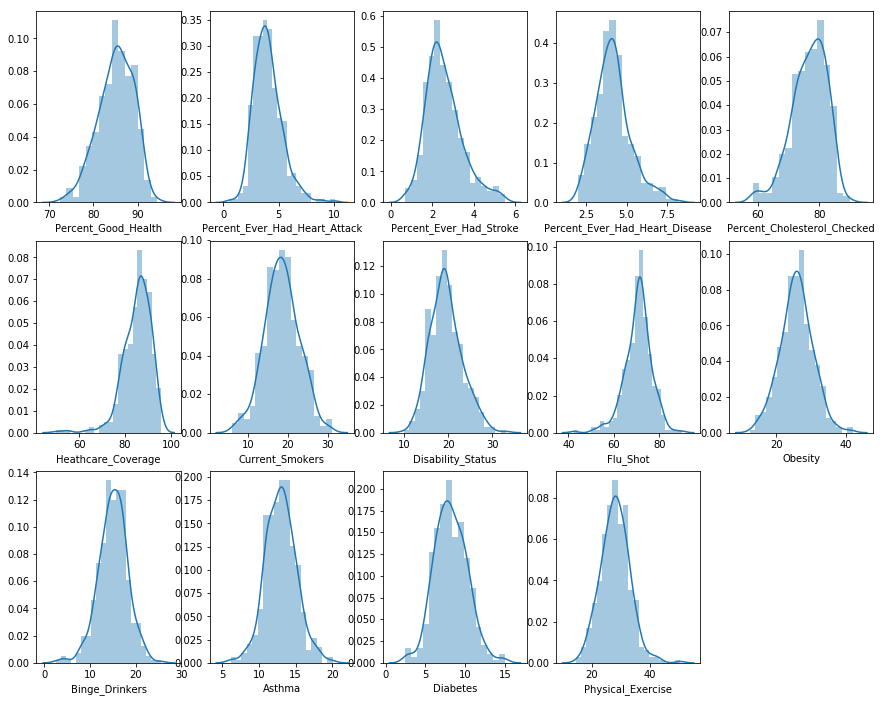

In [38]:
incomplete_cols = [col for col in data_brfss.columns if data_brfss[col].isnull().sum()>0] # columns with missing values
fig = plt.figure(figsize=(15,12))
for i in range(len(incomplete_cols)):
    col = incomplete_cols[i]
    plt.subplot(3,5,i+1)
    sns.distplot(data_brfss.loc[data_brfss[col].notnull(), col])
    plt.xlabel(col)
plt.show() 

There is some skewness to the data, such as `Percent_Ever_Had_Stroke` is skewed right and `Percent_Cholesterol_Checked` is skewed left. We could correct for skewness by manipulating the data using logarithm or squared, but since the histograms do not look heavily skewed, we have decided to skip this.

Instead of mean-imputation, due to slight divergence from the normal distribution, we will fill in missing values with the **median** of each feature.

In [39]:
for col in incomplete_cols:
    data_brfss[col] = data_brfss[col].fillna(data_brfss[col].median())

In [40]:
col_order = np.linspace(0,len(data_brfss.columns)-1,len(data_brfss.columns))
col_order[1] = 0
col_order[0] = 1
data_brfss = data_brfss.iloc[:,col_order]
data_brfss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403 entries, 0 to 402
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PERCENT_POVERTY                 403 non-null    float64
 1   CENSUS_2010_POP                 403 non-null    int64  
 2   Metropolitan                    403 non-null    int64  
 3   Median_HH_Income_pct_state      403 non-null    float64
 4   Ave_Unemployed_Rate             403 non-null    float64
 5   Percent_LT_HighSchool           403 non-null    float64
 6   Percent_HighSchool              403 non-null    float64
 7   Percent_Associate               403 non-null    float64
 8   Percent_Bachelor_GT             403 non-null    float64
 9   Heart_mortality_rate            403 non-null    float64
 10  Stroke_mortality_rate           403 non-null    float64
 11  AVE_BIRTH_RATE                  403 non-null    float64
 12  Percent_High_Speed              403 

# Data analysis on `data_brfss`

We will now perform analysis on this dataset, first splitting into train and test data, and then fitting to 4 regression models like above:
* OLS
* ElasticNet
* SVR
* RandomForest

In [41]:
y_data = data_brfss.iloc[:,0] # first column PERCENT_POVERTY
x_data = data_brfss.iloc[:,1:] # remaining columns
features = data_brfss.iloc[:,1:].columns

In [42]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_data)
x_data = scaler.transform(x_data) # no scaling y

In [43]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.2, random_state=0)

In [44]:
out_of_the_box(x_train, x_test)

OLS: (r_squared, rmse) = (0.7453164229476731, 5.459666708487621) 
ElasticNet: (r_squared, rmse) = (0.6389726253525414, 7.739364905379983) 
SVR: (r_squared, rmse) = (0.5858186312042443, 8.878830180814601) 
Forest: (r_squared, rmse) = (0.6985211587621174, 6.462819518518516) 


In contrast to the previous dataset, in `data_brfss` we see ordinary-least-squares linear regression perform the best with `r_squared` and `rmse` of `(0.74, 5.5)`. We will also take a look at the ElasticNet's `coef_` and RandomForest `feature_importances_` to determine features for our regression.

In [45]:
enet = linear_model.ElasticNet()
enet.fit(x_train, y_train)
features_enet = dict(zip(features, enet.coef_))
features_enet

{'CENSUS_2010_POP': 0.0,
 'Metropolitan': -0.0,
 'Median_HH_Income_pct_state': -0.8504831086673422,
 'Ave_Unemployed_Rate': 0.09202313544041239,
 'Percent_LT_HighSchool': 0.4718532959384948,
 'Percent_HighSchool': -0.0,
 'Percent_Associate': -0.0,
 'Percent_Bachelor_GT': -0.0,
 'Heart_mortality_rate': 0.006630205767664256,
 'Stroke_mortality_rate': 0.1982211125047354,
 'AVE_BIRTH_RATE': 0.6530351314865225,
 'Percent_High_Speed': -0.4086702309007468,
 'Percent_Good_Health': -0.3893529461284095,
 'Percent_Ever_Had_Heart_Attack': 0.0,
 'Percent_Ever_Had_Stroke': 0.003652189001432888,
 'Percent_Ever_Had_Heart_Disease': -0.0,
 'Percent_Cholesterol_Checked': -0.0,
 'Heathcare_Coverage': -0.546074131903817,
 'Current_Smokers': 0.001018807198112372,
 'Disability_Status': 0.0,
 'Flu_Shot': -0.0,
 'Obesity': 0.0,
 'Binge_Drinkers': 0.0,
 'Asthma': -0.0,
 'Diabetes': 0.3474224530365317,
 'Physical_Exercise': -0.0,
 'Pop_change_rate': -0.0,
 'Death_rate': 0.0,
 'Intl_migration_rate': 0.06868422440

For ElasticNet `coef_`, we see that a large number of BRFSS variables have zero coefficients, such as `Asthma` or `Physical_Exercise`. Looking at the features that have high coefficients, they are all features from the census dataset. And most importantly, these are the same features that were important in the previous `data_census` section!

In [46]:
features_enet = [k for (k,v) in enet_coefs_dict.items() if np.abs(v) > 0.01]
features_enet

['Median_HH_Income_pct_state',
 'Ave_Unemployed_Rate',
 'Percent_LT_HighSchool',
 'Percent_Associate',
 'Heart_mortality_rate',
 'Stroke_mortality_rate',
 'AVE_BIRTH_RATE',
 'Percent_High_Speed',
 'Domestic_migration_rate']

We can also repeat with Random Forest `feature_importances_` to confirm our observation from above.

In [47]:
forest = ensemble.RandomForestRegressor(random_state=0) # out-of-the-box
forest.fit(x_train, y_train)
forest_importance_dict = dict(zip(features, forest.feature_importances_))
forest_importance_dict

{'CENSUS_2010_POP': 0.010861781408553772,
 'Metropolitan': 8.930143225797269e-05,
 'Median_HH_Income_pct_state': 0.18788517837587246,
 'Ave_Unemployed_Rate': 0.007973817552683884,
 'Percent_LT_HighSchool': 0.044258248084350034,
 'Percent_HighSchool': 0.01392315670962613,
 'Percent_Associate': 0.02271141017713687,
 'Percent_Bachelor_GT': 0.008798902880147862,
 'Heart_mortality_rate': 0.015717400726398604,
 'Stroke_mortality_rate': 0.028123106122400765,
 'AVE_BIRTH_RATE': 0.31199397676779284,
 'Percent_High_Speed': 0.03207382097044905,
 'Percent_Good_Health': 0.15608538978949282,
 'Percent_Ever_Had_Heart_Attack': 0.004276909456963551,
 'Percent_Ever_Had_Stroke': 0.006752621495742688,
 'Percent_Ever_Had_Heart_Disease': 0.005156945943223639,
 'Percent_Cholesterol_Checked': 0.006446625678468615,
 'Heathcare_Coverage': 0.020271694914212914,
 'Current_Smokers': 0.004677244036083837,
 'Disability_Status': 0.00908896521849244,
 'Flu_Shot': 0.00564443208814534,
 'Obesity': 0.0067153145655090415,

In [49]:
features_forest = [k for (k,v) in forest_importance_dict.items() if np.abs(v) > 0.025]
features_forest

['Median_HH_Income_pct_state',
 'Percent_LT_HighSchool',
 'Stroke_mortality_rate',
 'AVE_BIRTH_RATE',
 'Percent_High_Speed',
 'Percent_Good_Health']

For feature importance, setting the same threshold as in the previous `data_census` case, we see almost the same set of important features. The only variable from BRFSS that made it into our list is `Percent_Good_Health`, which is still on the lower end of the importance spectrum compared to other predictors.

Let's try to compare the OLS regressor (which was the best *out-of-the-box*) and the optimized Random Forest regressor (which was the best for `data_census`, using cross-validation to tune hyperparameter), to see if we can improve performance in this subset of features.

In [50]:
# Out of the box with subset of features
subset_cols_idx = [i for i in range(len(features)) if features[i] in features_forest]
x_train_subset = x_train[:,subset_cols_idx]
x_test_subset = x_test[:,subset_cols_idx]
print('\nRandomForest:')
out_of_the_box(x_train_subset, x_test_subset)


RandomForest:
OLS: (r_squared, rmse) = (0.670860576819407, 7.0557810283177185) 
ElasticNet: (r_squared, rmse) = (0.6064806995923628, 8.435896214625142) 
SVR: (r_squared, rmse) = (0.5960482383624527, 8.659537495008236) 
Forest: (r_squared, rmse) = (0.6204882135143388, 8.135616320987651) 


**Model tuning: Random Forest**

Tuning has provided slight improvement using the subset of features. However, the performance is still much lower compared to models using `data_census` for prediction of `PERCENT_POVERTY`.

In [51]:
forest = ensemble.RandomForestRegressor(random_state=0)
n_estimators_values = [200, 300, 400]
max_depth_values = [8, 10, 12]
param_grid = {'n_estimators': n_estimators_values, 'max_depth': max_depth_values}
forest_cv = model_selection.GridSearchCV(forest, param_grid, cv=10)
forest_cv.fit(x_train_subset, y_train)
print(forest_cv.best_estimator_)
evaluate_model(forest_cv, x_test_subset, y_test)

RandomForestRegressor(max_depth=10, n_estimators=300, random_state=0)


(0.6278709453423155, 7.977352267822515)

# Summary

In summary, the smaller BRFSS data on behavioral risk do not include good features for prediction of the poverty rate of countries across the United States.

Even though we are enticed to draw conclusions regarding the relationship between mental health and poverty, we should be careful. Firstly, the BRFSS dataset is quite small (only 300-400 entries of data). Secondly, there is likely a selection bias in which counties with better resources have funding to conduct BRFSS surveys and underfunded counties where we expect high behavioral risk factors do not even carry out the BRFSS surveys. More BRFSS data on the missing counties is required to draw any substantive claims regarding the relationship of mental health and poverty rates.

We are reaffirmed by similar salient features in both the `data_census` and the small set `data_brfss` that contribute to poverty rates. Additionally, these features can only explain approximately 80% of the variability in `PERCENT_POVERTY`, so there must be other economic and social factors that affect difference in poverty between countries. Some of these features could include: number of companies based in county, availability of housing, state and local funding, social advance programs, percentage of people of color, etc. Future work can explore these features by scraping them from government data resources.